# Introduction



<img src="https://i.imgur.com/HRhd2Y0.png" width="1000" height="600"/>

# Setup notebook

## Install dependencies

In [1]:
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install pyarrow
! pip install requests
! pip install squarify
! pip install surprise
! pip install -U scikit-learn


## Import libraries

In [31]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

# Micellaneous
import requests 
import json
from datetime import datetime


# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD
from surprise.model_selection import GridSearchCV, train_test_split




## Load data

In [3]:
customers_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_customers_dataset.csv'
geolocation_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_geolocation_dataset.csv'
order_items_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_order_items_dataset.csv'
order_payments_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_order_payments_dataset.csv'
order_reviews_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_order_reviews_dataset.csv'
oders_ds = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_orders_dataset.csv'
products_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_products_dataset.csv'



customers_ds = pd.read_csv(customers_ds_url, sep=',')
geolocation_ds = pd.read_csv(geolocation_ds_url, sep=',')
order_items_ds = pd.read_csv(order_items_ds_url, sep=',')
order_payments_ds = pd.read_csv(order_payments_ds_url, sep=',')
order_reviews_ds = pd.read_csv(order_reviews_ds_url, sep=',')
order_ds = pd.read_csv(oders_ds, sep=',')
products_ds = pd.read_csv(products_ds_url, sep=',')

## Dataset Overview

In [4]:
# show the data without truncating
pd.set_option('display.max_colwidth', None)

In [5]:
def dataset_info(datasets, names):
    """
    This function receives a list of DataFrames and a list of names for each DataFrame and returns a DataFrame with useful information about all datasets.
    
    Parameters:
    --------
    datasets: list of DataFrames
    names: list of strings
    
    Returns:
    --------
        DataFrame: a DataFrame with useful information about all datasets
    """
    
    # Creating a DataFrame with useful information about all datasets
    data_info = pd.DataFrame({})
    data_info['dataset'] = names
    data_info['n_rows'] = [df.shape[0] for df in datasets]
    data_info['n_cols'] = [df.shape[1] for df in datasets]


    # Creating a separate DataFrame for columns
    columns_info = pd.concat([pd.DataFrame({'dataset': name, 'column': df.columns}) for name, df in zip(names, datasets)], ignore_index=True)
    # Creating a column with the data type for each column, respectively
    columns_info['dtype'] = [datasets[names.index(row['dataset'])][row['column']].dtype for i, row in columns_info.iterrows()]
    # creating a column with the number of null values for each column
    columns_info['null registers'] = [datasets[names.index(row['dataset'])][row['column']].isnull().sum() for i, row in columns_info.iterrows()]
    # creating a column with the percentage of null values for each column
    columns_info['null_%'] = [round(datasets[names.index(row['dataset'])][row['column']].isnull().mean() * 100, 2) for i, row in columns_info.iterrows()]
    # Unique values for each column
    columns_info['unique'] = [datasets[names.index(row['dataset'])][row['column']].nunique() for i, row in columns_info.iterrows()]
    # Duplicate values for each column
    columns_info['duplicates'] = [datasets[names.index(row['dataset'])][row['column']].duplicated().sum() for i, row in columns_info.iterrows()]
    # Merging the two DataFrames
    final_data_info = pd.merge(data_info, columns_info, on='dataset')    
    # Mean for numerical columns only
    final_data_info['mean'] = [datasets[names.index(row['dataset'])][row['column']].mean() if datasets[names.index(row['dataset'])][row['column']].dtype in ['int64', 'float64'] else None for i, row in final_data_info.iterrows()]    
    # Minimum for numerical columns only
    final_data_info['min'] = [datasets[names.index(row['dataset'])][row['column']].min() if datasets[names.index(row['dataset'])][row['column']].dtype in ['int64', 'float64'] else None for i, row in final_data_info.iterrows()]
    # Median for numerical columns only
    final_data_info['median'] = [datasets[names.index(row['dataset'])][row['column']].median() if datasets[names.index(row['dataset'])][row['column']].dtype in ['int64', 'float64'] else None for i, row in final_data_info.iterrows()]
    # Maximum for numerical columns only
    final_data_info['max'] = [datasets[names.index(row['dataset'])][row['column']].max() if datasets[names.index(row['dataset'])][row['column']].dtype in ['int64', 'float64'] else None for i, row in final_data_info.iterrows()]
    # Setting multiple columns as indexes
    final_data_info.set_index(['dataset', 'n_rows', 'n_cols', 'column'], inplace=True)
    final_data_info
    
    return final_data_info


datasets = [customers_ds, geolocation_ds, order_ds,  order_items_ds, products_ds, order_payments_ds, order_reviews_ds]
names = ['customers_ds', 'geolocation_ds', 'order_ds', 'order_items_ds', 'products_ds', 'order_payments_ds', 'order_reviews_ds']

dataset_info(datasets, names)

dtype  \
dataset           n_rows  n_cols column                                   
customers_ds      99441   5      customer_id                     object   
                                 customer_unique_id              object   
                                 customer_zip_code_prefix         int64   
                                 customer_city                   object   
                                 customer_state                  object   
geolocation_ds    1000163 5      geolocation_zip_code_prefix      int64   
                                 geolocation_lat                float64   
                                 geolocation_lng                float64   
                                 geolocation_city                object   
                                 geolocation_state               object   
order_ds          99441   8      order_id                        object   
                                 customer_id                     object   
                                 order_status                    object   
                                 order_purchase_timestamp        object   
                                 order_approved_at               object   
                                 order_delivered_carrier_date    object   
                                 order_delivered_customer_date   object   
                                 order_estimated_delivery_date   object   
order_items_ds    112650  7      order_id                        object   
                                 order_item_id                    int64   
                                 product_id                      object   
                                 seller_id                       object   
                                 shipping_limit_date             object   
                                 price                          float64   
                                 freight_value                  float64   
products_ds       32951   9      product_id                      object   
                                 product_category_name           object   
                                 product_name_lenght            float64   
                                 product_description_lenght     float64   
                                 product_photos_qty             float64   
                                 product_weight_g               float64   
                                 product_length_cm              float64   
                                 product_height_cm              float64   
                                 product_width_cm               float64   
order_payments_ds 103886  5      order_id                        object   
                                 payment_sequential               int64   
                                 payment_type                    object   
                                 payment_installments             int64   
                                 payment_value                  float64   
order_reviews_ds  99224   7      review_id                       object   
                                 order_id                        object   
                                 review_score                     int64   
                                 review_comment_title            object   
                                 review_comment_message          object   
                                 review_creation_date            object   
                                 review_answer_timestamp         object   

                                                                null registers  \
dataset           n_rows  n_cols column                                          
customers_ds      99441   5      customer_id                                 0   
                                 customer_unique_id                          0   
                                 customer_zip_code_prefix                    0   
                                 customer_city         

## Create a core dataframe

Here we will create a core dataframe that merge the main dataframe, order_ds, with the others relevants dataframes by the key columns.

In [6]:
# merge order_merged with customers_ds
order_merged = order_ds.merge(customers_ds, on='customer_id', how='left')
# merge order_ds with order_items_ds
order_merged = order_merged.merge(order_items_ds, on='order_id', how='left')
# merge order_merged with products_ds
order_merged = order_merged.merge(products_ds, on='product_id', how='left')
# merge order_merged with order_reviews_ds
order_merged = order_merged.merge(order_reviews_ds, on='order_id', how='left')
# merge order_merged with order_payments_ds
order_merged = order_merged.merge(order_payments_ds, on='order_id', how='left')


dataset_info([order_merged], ['order_merged'])

dtype  \
dataset      n_rows n_cols column                                   
order_merged 119143 36     order_id                        object   
                           customer_id                     object   
                           order_status                    object   
                           order_purchase_timestamp        object   
                           order_approved_at               object   
                           order_delivered_carrier_date    object   
                           order_delivered_customer_date   object   
                           order_estimated_delivery_date   object   
                           customer_unique_id              object   
                           customer_zip_code_prefix         int64   
                           customer_city                   object   
                           customer_state                  object   
                           order_item_id                  float64   
                           product_id                      object   
                           seller_id                       object   
                           shipping_limit_date             object   
                           price                          float64   
                           freight_value                  float64   
                           product_category_name           object   
                           product_name_lenght            float64   
                           product_description_lenght     float64   
                           product_photos_qty             float64   
                           product_weight_g               float64   
                           product_length_cm              float64   
                           product_height_cm              float64   
                           product_width_cm               float64   
                           review_id                       object   
                           review_score                   float64   
                           review_comment_title            object   
                           review_comment_message          object   
                           review_creation_date            object   
                           review_answer_timestamp         object   
                           payment_sequential             float64   
                           payment_type                    object   
                           payment_installments           float64   
                           payment_value                  float64   

                                                          null registers  \
dataset      n_rows n_cols column                                          
order_merged 119143 36     order_id                                    0   
                           customer_id                                 0   
                           order_status                                0   
                           order_purchase_timestamp                    0   
                           order_approved_at                         177   
                           order_delivered_carrier_date             2086   
                           order_delivered_customer_date            3421   
                           order_estimated_delivery_date               0   
                           customer_unique_id                          0   
                           customer_zip_code_prefix                    0   
                           customer_city                               0   
                           customer_state                              0   
                           order_item_id                             833   
                           product_id                                833   
                           seller_id                                 833   
                           shipping_limit_date                       833   
                           price                                     

---
# Stage 1 - Analysis of orders and customers segments 
---

## Orders Analysis

### Evolution of orders over time and geographic region share

To understand the evolution of orders over time, we can plot the number of orders per month and the geographic region share of orders. For this, first we have to get the geographic region of each stats from Brazil by an API. 

In [7]:
# stablisihing a connection with the IBGE API
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
# getting the content of the request
data = [c['UF'] for c in json.loads(r.text)]
# creating a DataFrame with the data
brazil_regions = pd.DataFrame(data)
# selecting only the columns of interest
brazil_regions['regiao'] = brazil_regions['regiao'].apply(lambda x: x['nome'])
brazil_regions.drop_duplicates(inplace=True)
# drop id column
brazil_regions.drop(columns=['id'], inplace=True)
# rename the columns
brazil_regions.columns = ['uf', 'state_name', 'region']
brazil_regions.sample(5)

,uf,state_name,region
18,TO,Tocantins,Norte
4,AM,Amazonas,Norte
74,ES,Espírito Santo,Sudeste
25,PI,Piauí,Nordeste
115,RS,Rio Grande do Sul,Sul


Now, let's merge the previous data with the order dataframe.

In [8]:
# merge the order_merged with the brazil_regions
order_merged = order_merged.merge(brazil_regions, left_on='customer_state', right_on='uf', how='left')
# drop uf column
order_merged.drop(columns=['uf'], inplace=True)
order_merged[['order_id','customer_state', 'region']].sample(5)

,order_id,customer_state,region
99798,9d116cdcb1a5c14a35e00b7ad54914ee,RJ,Sudeste
40438,23f958d8fed53e69461c299f20da7a11,SP,Sudeste
118699,a68b3ae8450a14f9ba0cc1b53574af62,SP,Sudeste
78619,8dc8685118410f97bea9569d280d64c4,SP,Sudeste
16417,15575c6a363e9f5da19a7b7f364976a1,PR,Sul


We can also format the date column to datetime format and create a new column with the month and year of the order.

In [9]:
# Formatting the date columns
order_merged['order_purchase_timestamp'] = pd.to_datetime(order_merged['order_purchase_timestamp'])
order_merged['order_purchase_date'] = order_merged['order_purchase_timestamp'].dt.date
order_merged['order_purchase_year_month'] = order_merged['order_purchase_timestamp'].apply(lambda x: x.strftime('%y-%m'))

Seeing the evolution of orders over time, we can see that the number of orders has been increasing with relevance since 2017, with a peak in november 2017, probably due to the black friday. However, there is sudden drop in september 2018, which could be due to some external factor. 

Text(0, 0.5, 'Orders')

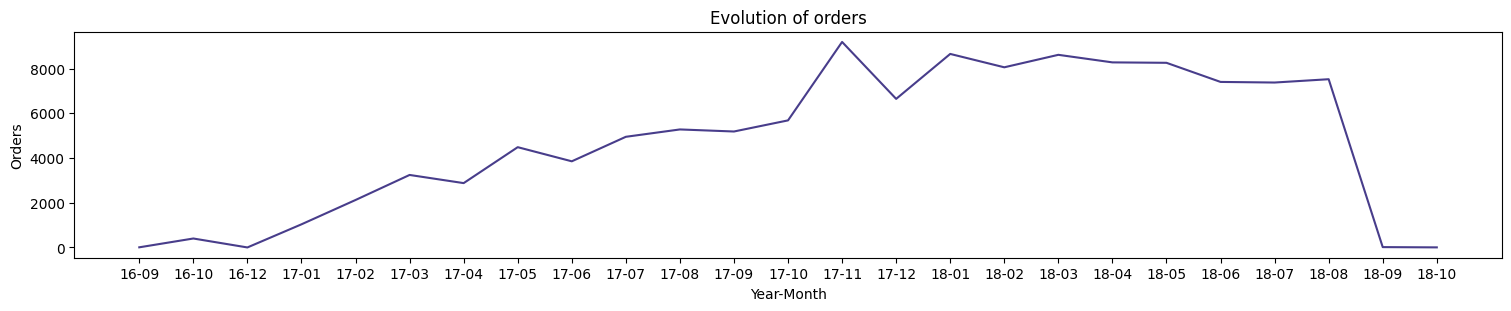

In [10]:
plt.figure(constrained_layout=True, figsize=(15, 3))
# Plotting the number of orders in each region for each year-month
sns.lineplot(data=order_merged['order_purchase_year_month'].value_counts().sort_index(), color='darkslateblue')
# change the size of the plot
plt.title('Evolution of orders')
# xlabel
plt.xlabel('Year-Month')
# ylabel
plt.ylabel('Orders')

Because of these behaviors on extreme periods, we can see that the best period to analyze the data is from 2017 to august 2018.

In [11]:
# filter the data to get only the year 2017
order_merged_filtered = order_merged[(order_merged['order_purchase_year_month'] >= '17-01') & (order_merged['order_purchase_year_month'] < '18-09')]

Grouping the orders by region, state and city, we can plot the number of orders per month and the geographic region share of orders.

In [12]:
# Grouping orders by year-month and region. Aggregating by count of orders and payment_value
region_orders = order_merged_filtered.groupby(['order_purchase_year_month', 'region']).agg({'order_id': 'count'}).reset_index()
# renaming the columns
region_orders.columns = ['order_purchase_year_month', 'region', 'orders']
# Share of orders in each region for each year-month
region_orders['total_orders_month'] = region_orders.groupby('order_purchase_year_month')['orders'].transform('sum')
region_orders['share_month'] = 100*region_orders['orders'] / region_orders['total_orders_month']


# Grouping orders by year-month and state
state_orders = order_merged_filtered.groupby(['order_purchase_year_month', 'customer_state']).agg({'order_id': 'count'}).reset_index()

# Grouping orders by year-month and city
city_orders = order_merged_filtered.groupby(['order_purchase_year_month', 'customer_city']).agg({'order_id': 'count'}).reset_index()

# Grouping orders by year-month, region and product_category_name
region_category_orders = order_merged_filtered.groupby(['order_purchase_year_month', 'region', 'product_category_name']).agg({'order_id': 'count'}).reset_index()

Text(0, 0.5, 'Share of orders (%)')

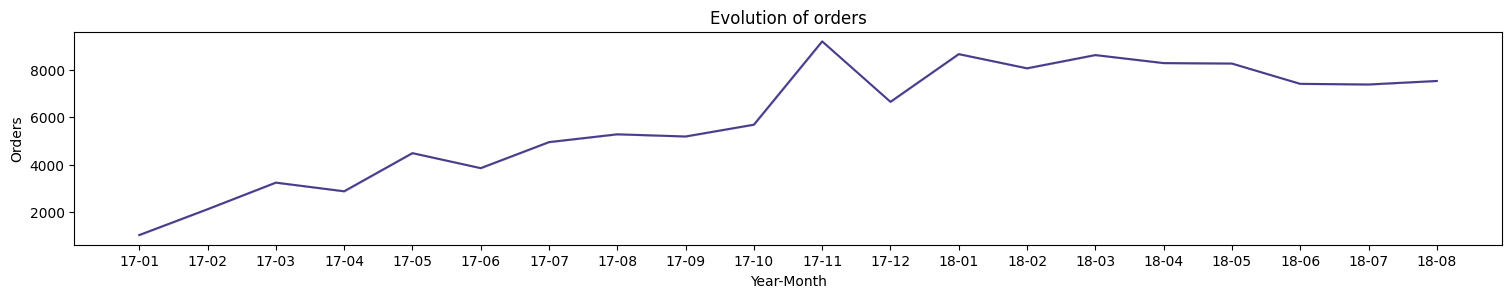

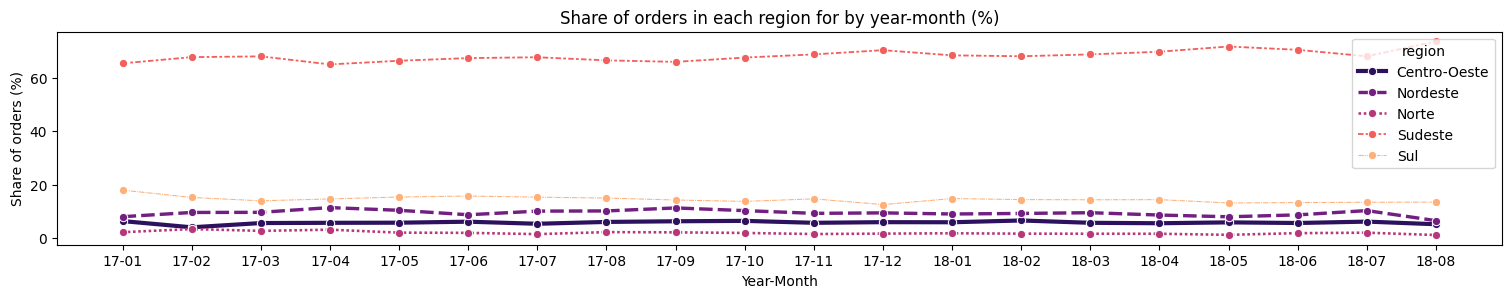

In [13]:
plt.figure(constrained_layout=True, figsize=(15, 5))
# subplot 1
plt.subplot(2, 1, 1)
# Plotting the number of orders in each region for each year-month
sns.lineplot(data=region_orders, x='order_purchase_year_month', y='total_orders_month', color='darkslateblue', markers=['o'] * 5)
# change the size of the plot
plt.title('Evolution of orders')
# xlabel
plt.xlabel('Year-Month')
# ylabel
plt.ylabel('Orders')

plt.figure(constrained_layout=True, figsize=(15, 5))
plt.subplot(2, 1, 2)
# Plotting the share of orders in each region for each year-month
sns.lineplot(data=region_orders, x='order_purchase_year_month', y='share_month', hue='region', size='region', style='region', palette='magma', markers=['o'] * 5)
# change the size of the plot
plt.title('Share of orders in each region for by year-month (%)')
# xlabel
plt.xlabel('Year-Month')
# ylabel
plt.ylabel('Share of orders (%)')

---
# Stage 2 - User segmentation by RFM
---


RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

* Recency (R): Who have purchased recently? Number of days since last purchase (least recency)
* Frequency (F): Who has purchased frequently? It means the total number of purchases. (high frequency)
* Monetary Value (M): Who have high purchase amount? It means the total money customer spent (high monetary value)

We can calculate the RFM values for each customer and then segment them into different groups based on these values.

**Customer score**

The customer score ranges from 1 to 5, with 5 being the best score. The score is calculated based on the RFM values as follows:

* Recency: 5 - The customer made a purchase recently
* Frequency: 5 - The customer made frequent purchases
* Monetary Value: 5 - The customer spent a lot of money



Sources: 
1. https://documentation.bloomreach.com/engagement/docs/rfm-segmentation
2. https://blog.rsquaredacademy.com/customer-segmentation-using-rfm-analysis/
3. https://medium.com/maxmilhas-tech/o-que-%C3%A9-rfm-e-como-aplic%C3%A1-lo-ao-seu-time-de-customer-service-b9c35817ed01
   

## Data Preparation

First, we will check only orders with status delivered, to consider the orders that were actually completed.

In [14]:
def summary_category(df, feature):
    """
    Calculate the amount of occurrences of each category level in dataset, as well their
    proportion.

    Parameters
    ----------
    df : pandas.DataFrame
    feature : a categorical column of from df

    Returns
    ----------
    df_aux : pandas.DataFrame
    """

    s = df[feature].copy()
    # Count the occurrences of each category level
    counts = s.value_counts()
    # Calculate the proportion of occurrences
    percent100 = s.value_counts(normalize=True).mul(100).round(3)
    # Build a dataframe
    df_aux = pd.DataFrame({'Count': counts, '%': percent100})
    # Set a title
    index = df_aux.index
    index.name = feature

    df_aux = df_aux.reset_index(level=0)

    return df_aux

As we can see, the delivered orders are the majoraty, corresponding to 97% of the orders.

In [15]:
summary_category(order_ds, 'order_status')

,order_status,Count,%
0,delivered,96478,97.020
1,shipped,1107,1.113
2,canceled,625,0.629
3,unavailable,609,0.612
4,invoiced,314,0.316
5,processing,301,0.303
6,created,5,0.005
7,approved,2,0.002


In [16]:
# Filtering only the orders that have been delivered
order_merged_delivered = order_merged_filtered[order_merged_filtered['order_status'] == 'delivered']

It's important to define the date of the last order transaction, since the this dataset has data until the end of 2018. So, we will consider the last date of the dataset as the reference date. Remember that the dataset had been filtered previously to consider registers only until august 2018.

In [17]:
# Get last transaction date to help calculate Recency
max_trans_date = max(order_merged_filtered.order_purchase_timestamp).date()
max_trans_date

datetime.date(2018, 8, 31)

## Recency, Frequency and Monetary Value

Now, let's create the RFM dataframe, by joining the customers dataframe with the order dataframe and then calculate the RFM values for each customer.

In [18]:

# Group orders by customer_unique_id and aggregating by the sum of payment_value, count of product_id and the last purchase date
customers_rfm = order_merged_filtered.groupby('customer_unique_id').agg(
    {
    # difference between the last purchase date and the last transaction date
    'order_purchase_timestamp': lambda x:(datetime.strptime(str(max_trans_date),'%Y-%m-%d') - x.max()).days, 
    'product_id': lambda x:len(x), # count of product_id
    'payment_value': lambda x:sum(x)} # sum of payment_value
    )
# renaming the columns
customers_rfm.columns = ['recency', 'frequency', 'monetary']


In [19]:
customers_rfm.sample(5)

,recency,frequency,monetary
customer_unique_id,,,
fb0f4535f3d7f34617ebe8407cdec4d1,230,1,247.85
ca681af5ab07e1b26a4a7322d06b0948,462,1,51.00
cf6e43279e51aaedf0f39337b5375c71,392,1,55.00
9c96aceebc6283e7e700993256b62609,278,1,170.69
7c61df63da03abb1153e68b3bf758f0e,3,1,20.27


### Plot recency, frequency and monetary value distributions

In order to visualize the distribution of the RFM values, we can plot the histograms of the recency, frequency and monetary value. Also, we can see the occurrence of outliers in the data.

Text(0.5, 1.0, 'Monetary distribution')

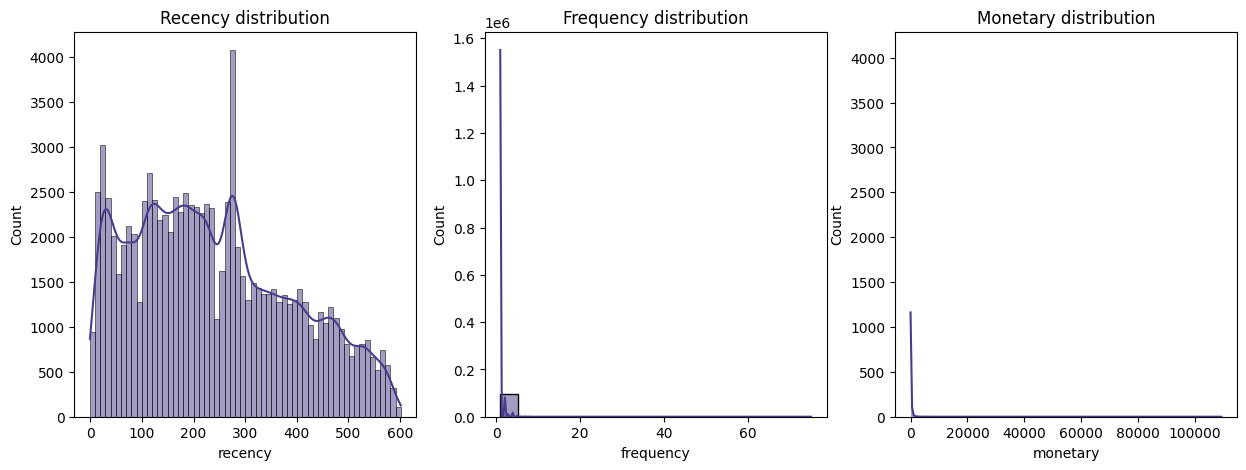

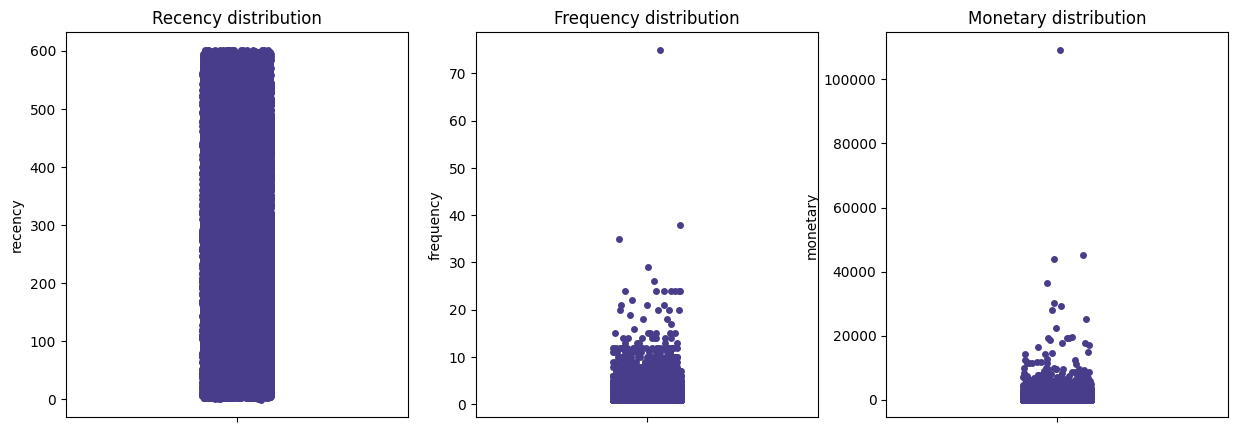

In [20]:
# Plot histograms
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# Plotting the Recency distribution
sns.histplot(customers_rfm['recency'], kde=True, ax=ax[0], color='darkslateblue')
ax[0].set_title('Recency distribution')

sns.histplot(customers_rfm['frequency'], kde=True, ax=ax[1], color='darkslateblue')
ax[1].set_title('Frequency distribution')

sns.histplot(customers_rfm['monetary'], kde=True, ax=ax[2], color='darkslateblue')
ax[2].set_title('Monetary distribution')

# Plot stripplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.stripplot(data=customers_rfm['recency'], ax=ax[0], color='darkslateblue')
ax[0].set_title('Recency distribution')

sns.stripplot(data=customers_rfm['frequency'], ax=ax[1], color='darkslateblue')
ax[1].set_title('Frequency distribution')

sns.stripplot(data=customers_rfm['monetary'], ax=ax[2], color='darkslateblue')
ax[2].set_title('Monetary distribution')

In [21]:
customers_rfm.describe(percentiles=[0.05, 0.95])

,recency,frequency,monetary
count,95774.000000,95774.000000,95774.000000
mean,238.636091,1.239522,214.021213
std,151.431042,0.853049,645.578019
min,-1.000000,1.000000,0.000000
5%,24.000000,1.000000,32.700000
50%,220.000000,1.000000,113.330000
95%,519.000000,2.000000,667.993500
max,602.000000,75.000000,109312.640000


## Recency, Frequency and Monetary scores

The scores for each parameter will be calculated based on the quintiles of the values. The scores will range from 1 to 5, with 5 being the best score.
After that, the RFM score is given by: 

$RFM\_score= 100*recency\_score + 10*frequency\_score + monetary\_score$


In [22]:
# for r_score, the lower the recency, the better
customers_rfm['r_score'] = pd.qcut(customers_rfm['recency'], q=5, labels=[5, 4, 3, 2, 1]).astype(int)
# for f_score, it's necessary to rank the values first, because there are many repeated values
customers_rfm['f_score'] = pd.qcut(customers_rfm['frequency'].rank(method= 'first'), 5, [1, 2, 3, 4, 5]).astype(int)
customers_rfm['m_score'] = pd.qcut(customers_rfm['monetary'], q=5, labels=[1, 2, 3, 4, 5]).astype(int)

# calculating the RFM score
customers_rfm['RFM'] = 100*customers_rfm['r_score'] + 10*customers_rfm['f_score'] + customers_rfm['m_score']
customers_rfm.sample(5)

,recency,frequency,monetary,r_score,f_score,m_score,RFM
customer_unique_id,,,,,,,
4fa8f0f2f68d0111c26474ba4dc5e264,274,1,272.71,2,2,5,225
14ffbd4de199c166e48838c0877b2ccb,17,1,225.62,5,1,4,514
3bbf03908fb2863f5537cec78cf5f70b,19,1,47.53,5,1,1,511
8c1cc735707667f8df0c4de762b0c92a,475,1,33.09,1,3,1,131
73d3884f3b6a73d8284a92783cb0f674,101,1,35.78,4,2,1,421


## Customer Segmentation

The customer segmentation will be done based on the RFM score. The customers will be divided into the following segments:

| Client Segment       | Behavior                                                                   | Potential Strategies                                                                                                               |
|----------------------|----------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------|
| Champion             | Completed a recent purchase. They buy frequently and spend the most.       | Reward them. Can be early adopters of new products. They act as brand ambassadors.                                                  |
| Loyal Customer       | They buy frequently and spend a lot of money on the site. Sensitive to offers. | Upsell. Offer high-value items to them. Ask them for reviews. Build loyalty.                                                        |
| Potential Loyalist   | They recently spent a fair amount of money on the site more than once.     | Invite them to join a loyalty program or to get a membership. Recommend other products to them.                                     |
| New Customer         | Completed a recent purchase, but doesn’t order often.                      | Support them on their onboarding process. Get their satisfaction. Start to build loyalty.                                          |
| Promising            | Completed a recent purchase, but didn’t spend a lot.                       | Create brand awareness. Offer discounts, gifts and free trials.                                                                      |
| Need Attention       | Above average in recency, frequency and monetary value, but no recent purchases. | Launch limited-time offers and recommendations based on previous orders. Reactivate.                                              |
| Cannot Lose Them     | Completed huge, frequent purchases long ago but haven’t come back since then.| Get them back with new product launches. Don’t let competitors take them. Talk to them.                                            |
| About To Sleep       | Below average in recency, frequency and monetary value. At risk of losing them if you don’t reactivate. | Share useful information. Recommend popular products to them. Offer new discounts. Reconnect.                                       |
| At Risk              | Completed big, frequent purchases long ago. You need to bring them back!     | Send personalized emails to reconnect with special offers. Share useful resources with them.                                         |
| Hibernating          | Their last purchase was long ago. The number of orders was small and the amounts spent low. | Offer relevant products and special discounts. Create brand value again.                                                           |
| Lost                 | Lowest scores in recency, frequency and monetary value.                     | Try to reactivate them with personalized campaigns. If it doesn’t work, ignore them.                                               |



The segments are defined based on the RFM score as follows:


| Client Segment       | RFM                                       | 
|----------------------|-------------------------------------------|
| Champion             | 555, 554, 544, 545, 454, 455, 445         |
| Loyal Customer       | 543, 444, 435, 355, 354, 345, 344, 335    |
| Potential Loyalist   | 553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323|
| New Customer         | 512, 511, 422, 421, 412, 411, 311         |
| Promising            | 525, 524, 523, 522, 521, 515, 514, 513,425,424, 413,414,415, 315, 314, 313|
| Need Attention       | 535, 534, 443, 434, 343, 334, 325, 324    |
| Cannot Lose Them     | 155, 154, 144, 214, 215, 115, 114, 113    |
| About To Sleep       | 331, 321, 312, 221, 213                   |
| At Risk              | 255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124|
| Hibernating          | 332, 322, 231, 241, 251, 233, 232, 223, 332, 322, 231, 241, 251, 233, 232, 223, 222, 132, 123, 122, 212, 211|
| Lost                 | 111, 112, 121, 131, 141, 151              |

Source: https://connectif.ai/en/blog/what-are-rfm-scores-and-how-to-calculate-them/

In [23]:
def segment_from_rfm(rfm_score):
    segments = {
        'Champion': ['555', '554', '544', '545', '454', '455', '445'],
        'Loyal Customer': ['543', '444', '435', '355', '354', '345', '344', '335'],
        'Potential Loyalist': ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'],
        'New Customer': ['512', '511', '422', '421', '412', '411', '311'],
        'Promising': ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313'],
        'Need Attention': ['535', '534', '443', '434', '343', '334', '325', '324'],
        'Cannot Lose Them': ['155', '154', '144', '214', '215', '115', '114', '113'],
        'About To Sleep': ['331', '321', '312', '221', '213'],
        'At Risk': ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'],
        'Hibernating': ['332', '322', '231', '241', '251', '233', '232', '223', '332', '322', '231', '241', '251', '233', '232', '223', '222', '132', '123', '122', '212', '211'],
        'Lost': ['111', '112', '121', '131', '141', '151']
    }

    # convert to string if the RFM score is an integer
    if isinstance(rfm_score, int):
        rfm_score_str = str(rfm_score)

    for segment, scores in segments.items():
        if rfm_score_str in scores:
            return segment

    return 'Unknown'




In [24]:
customers_rfm['customer_segment'] = customers_rfm['RFM'].apply(segment_from_rfm)
customers_rfm.sample(5)

,recency,frequency,monetary,r_score,f_score,m_score,RFM,customer_segment
customer_unique_id,,,,,,,,
b4d1f56f68542720cc2dbe7d2a594836,35,1,44.87,5,4,1,541,Potential Loyalist
5b19b3434d9c9e51703f9b53abe7d0f6,216,1,196.02,3,2,4,324,Need Attention
4a432ac3e75f3d02cab410e0e810e46a,273,1,91.96,2,2,3,223,Hibernating
483293828ba25e350c560f5d91507b7c,433,1,100.33,1,2,3,123,Hibernating
8aaf91dd432b5099088be2cd4696064b,126,2,1442.12,4,5,5,455,Champion


In [25]:
summary_category(customers_rfm, 'customer_segment')

,customer_segment,Count,%
0,Potential Loyalist,16414,17.138
1,At Risk,15453,16.135
2,Promising,11712,12.229
3,Hibernating,11449,11.954
4,Champion,7120,7.434
5,Cannot Lose Them,6516,6.804
6,Loyal Customer,6362,6.643
7,New Customer,5928,6.190
8,Need Attention,5743,5.996
9,Lost,4911,5.128


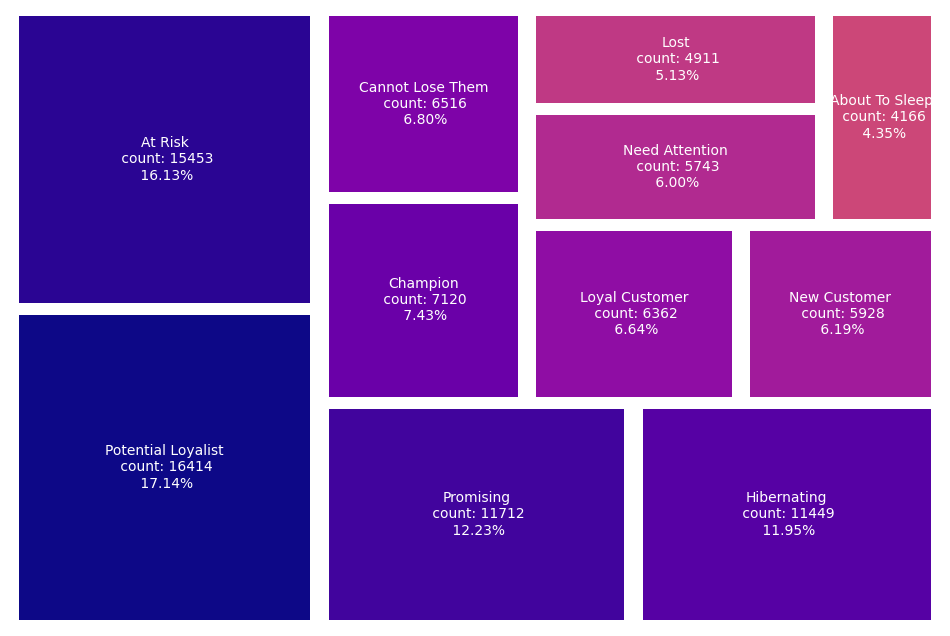

In [26]:
import matplotlib.pyplot as plt
import squarify

# Use squarify to plot the treemap of the segments
plt.figure(figsize=(12, 8))

# Data
segment_counts = customers_rfm['customer_segment'].value_counts()
total = segment_counts.sum()
labels = [f'{segment}\n count: {count}\n {count/total:.2%}' for segment, count in segment_counts.items()]
values = segment_counts.values

# Define colors
colors = plt.cm.plasma(np.linspace(0, 0.5, len(labels)))

# Treemap
squarify.plot(sizes = values, label = labels, color = colors,
              pad = 0.1,
              text_kwargs = {'fontsize': 10, 'color': 'white'}
              )

# Remove the axis:
plt.axis("off")

plt.show()

---
# Stage 3 - Products recommendation
---

In [27]:
customers_rfm

,recency,frequency,monetary,r_score,f_score,m_score,RFM,customer_segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,4,414,Promising
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4,1,1,411,New Customer
0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112,Lost
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211,Hibernating
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214,Cannot Lose Them
...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,2,4134.84,1,5,5,155,Cannot Lose Them
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58,3,5,2,352,Potential Loyalist
ffff371b4d645b6ecea244b27531430a,569,1,112.46,1,5,3,153,At Risk


In [47]:
def create_puchase_count_df(data):
    
    # Count how many times a customer bought a product
    purchase_counts = (
        data.set_index('customer_unique_id')['product_id']
        .apply(pd.Series)
        .reset_index()
        .melt(id_vars=['customer_unique_id'], value_name='product_id')
        .dropna()
        .drop(['variable'], axis=1)
        .groupby(['customer_unique_id', 'product_id'])
        .agg({'product_id': 'count'})
        .rename(columns={'product_id': 'estimator'})
        .reset_index()
    )
    
    scaler = MinMaxScaler()
    purchase_counts[['estimator']] = scaler.fit_transform(purchase_counts[['estimator']])
    purchase_counts['estimator'] = purchase_counts['estimator'].fillna(0.0)

    return purchase_counts

def create_review_score_df(data):

    # Calculate the mean review score for each product bought by each customer
    user_prod_reviewscore = (
        data.groupby(['customer_unique_id','product_id'])['review_score']
        .mean()
        .reset_index()
        .rename(columns={'review_score':'estimator'})
    )
    
    scaler = MinMaxScaler()
    user_prod_reviewscore['estimator'] = scaler.fit_transform(user_prod_reviewscore[['estimator']])
    user_prod_reviewscore['estimator'] = purchase_counts['estimator'].fillna(0.0)
    
    return user_prod_reviewscore



def create_product_relevance_score(purchase_counts, user_prod_reviewscore, customers_rfm):
    
    # Rename column to avoid conflicts
    purchase_counts_ = purchase_counts.rename(columns={'estimator': 'purchase_counts'})
    user_prod_reviewscore_ = user_prod_reviewscore.rename(columns={'estimator': 'mean_review'})
    
    # Merge the two DataFrames
    merged = purchase_counts_.merge(user_prod_reviewscore_, on=['customer_unique_id', 'product_id'], how='left')
    
    customers_rfm_ = customers_rfm.reset_index()
    purchase_counts_rmf = merged.merge(customers_rfm_[['customer_unique_id', 'RFM']].reset_index(), on='customer_unique_id', how='left')
    purchase_counts_rmf.drop('index', axis=1, inplace=True)
    # purchase_counts_rmf['mean_review'].fillna(0.0, inplace=True)
    
    scaler = MinMaxScaler()
    purchase_counts_rmf[['purchase_counts', 'mean_review', 'RFM']] = scaler.fit_transform(purchase_counts_rmf[['purchase_counts', 'mean_review', 'RFM']])
    purchase_counts_rmf['estimator'] = 0.7*purchase_counts_rmf['purchase_counts'] + 0.2*purchase_counts_rmf['mean_review'] + 0.1*purchase_counts_rmf['RFM']
    purchase_counts_relevance = purchase_counts_rmf[['customer_unique_id', 'product_id', 'estimator']]
    
    return purchase_counts_relevance, purchase_counts_rmf

purchase_counts = create_puchase_count_df(order_merged_delivered)
user_prod_reviewscore = create_review_score_df(order_merged_delivered)
product_relevance, purchase_counts_rmf = create_product_relevance_score(purchase_counts, user_prod_reviewscore, customers_rfm)


In [ ]:
from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split

def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','product_id','estimator']], reader)
    
    return df

# Split data into 5 kfolds
kf = KFold(n_splits=5, shuffle=True, random_state=19)

# Helper function to test different types of collaborative filtering
def model_framework(train_data):
    
    test_df = surprise_df(train_data)
    
    normp_rmse, svd_rmse = [], [] 

    for trainset, testset in kf.split(test_df): #iterate through the folds.
        
        #baseline
        normp = NormalPredictor()
        normp.fit(trainset)
        normp_pred = normp.test(testset)
        normp_rmse.append(accuracy.rmse(normp_pred,verbose=False))
        
        params = {'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.4}
        svd = SVD(
            n_factors=params['n_factors'], 
            n_epochs=params['n_epochs'],
            lr_all=params['lr_all'], 
            reg_all=params['reg_all']
        )

        svd.fit(trainset)
        svd_pred = svd.test(testset)
        svd_rmse.append(accuracy.rmse(svd_pred,verbose=False))
        
    mean_rmses = [np.mean(normp_rmse),
                  np.mean(svd_rmse)
                  ]
    
    model_names = ['baseline', 'svd']
    compare_df = pd.DataFrame(mean_rmses, index=model_names)
    
    return compare_df

In [ ]:
def model_comparison(all_methods):
    comp_matrix = model_framework(all_methods[0]).transpose()
    print('Initial dataframe created.')
    
    for method in all_methods[1:]:
        temp_df = model_framework(method).transpose()
        comp_matrix = pd.concat((comp_matrix,temp_df), axis=0)
        print("Layer added to dataframe.")
        
    comp_matrix = comp_matrix.set_index([['purchase_counts', 
                                       'user_prod_reviewscore',
                                       'product_relevance']])
    
    return comp_matrix

In [ ]:
all_methods = [purchase_counts, user_prod_reviewscore, product_relevance]
comparison_matrix = model_comparison(all_methods)


Initial dataframe created.
Layer added to dataframe.
Layer added to dataframe.


In [ ]:
comparison_matrix

,baseline,svd
purchase_counts,0.020122,0.016782
user_prod_reviewscore,0.020183,0.016744
product_relevance,0.048890,0.031154


In [ ]:
def gridsearch(data, model, param_grid, njobs=4):
    param_grid = param_grid
    gs = GridSearchCV(model, param_grid, measures=['rmse'], cv=5, n_jobs=njobs)
    gs.fit(data)
    
    new_params = gs.best_params['rmse']
    best_score = gs.best_score['rmse']
    
    print("Best score:", best_score)
    print("Best params:", new_params)
    
    return new_params, best_score

In [ ]:

# standard svd gridsearch
data = surprise_df(purchase_counts_relevance)

svd_param_grid = {'n_factors': [25, 50,100],'n_epochs': [20,30,50], 'lr_all': [0.002,0.005,0.01],
              'reg_all':[0.02,0.1, 0.4]}

svd_params, svd_score = gridsearch(data, SVD, svd_param_grid, 8)

Best score: 0.05936291559678354
Best params: {'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.4}


In [51]:

def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','product_id','estimator']], reader)
    
    return df


def final_model(data):
    
    user_ratings_matrix = surprise_df(data)
    
    train_set, test_set = train_test_split(user_ratings_matrix, test_size=0.2, random_state=19)
    
    params = {'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.4}
    svdpp = SVD(n_factors=params['n_factors'], 
                    n_epochs=params['n_epochs'],
                    lr_all=params['lr_all'], 
                    reg_all=params['reg_all'])
    svdpp.fit(train_set)
    predictions = svdpp.test(test_set)
    rmse = accuracy.rmse(predictions,verbose=False)
            
    return predictions, rmse, train_set
    
final_predictions, final_rmse, train_set = final_model(product_relevance)

TypeError: Singleton array array(<surprise.dataset.DatasetAutoFolds object at 0x729911526150>,
      dtype=object) cannot be considered a valid collection.

In [ ]:


def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(train_set.ur[train_set.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(train_set.ir[train_set.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

recommendation_results = pd.DataFrame(final_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
recommendation_results['Iu'] = recommendation_results.uid.apply(get_Iu)
recommendation_results['Ui'] = recommendation_results.iid.apply(get_Ui)
recommendation_results['err'] = abs(recommendation_results.est - recommendation_results.rui)

In [ ]:
recommendation_results.loc[recommendation_results.uid=='cbd70d39b38dc382a7104dca8fa6ad28']

,uid,iid,rui,est,details,Iu,Ui,err
10,cbd70d39b38dc382a7104dca8fa6ad28,9ae64e1163bf254bad20d5155cffb99d,0.20991,0.210628,{'was_impossible': False},0,9,0.000718
4761,cbd70d39b38dc382a7104dca8fa6ad28,9bebdd5c142f3d0052c0377cc80b9385,0.20991,0.225903,{'was_impossible': False},0,1,0.015993


In [ ]:
best_predictions = recommendation_results.sort_values(by='err')[:10]
best_predictions


,uid,iid,rui,est,details,Iu,Ui,err
1268,9dc4691698a7fd81f292f289b5181120,2197e985613d6f73425b6baf8401c728,0.227477,0.227484,{'was_impossible': False},0,1,0.000007
5567,555f8bf70ca6d707e83c484e3ff359c3,ddbcffa21df7d85a96fc395a6d9ca334,0.202252,0.202261,{'was_impossible': False},0,1,0.000009
1089,65cdf5ca38fd0667a658101672cb46d1,a1bf559ac1eab015ba992bd76d9d76c7,0.202252,0.202240,{'was_impossible': False},0,16,0.000012
12486,b52a4b465bfc5a1c7e9033f7b7d8f3dd,36f60d45225e60c7da4558b070ce4b60,0.212027,0.212040,{'was_impossible': False},0,93,0.000013
6610,1a3c5d92c5273cce2508cbbcf40d5267,f71973c922ccaab05514a36a8bc741b8,0.200450,0.200465,{'was_impossible': False},0,53,0.000015
18719,1b95023e493953fdf09bec476f58e678,369dfa384d5ad2a0cb97cb4cda846c47,0.200676,0.200692,{'was_impossible': False},0,6,0.000017
14586,681b1f6f853abf792786c3429e8e8633,cef211702e18d39ca1a4b6d2d6580c0d,0.226983,0.227000,{'was_impossible': False},0,1,0.000017
11395,91d566fccdd231e7906ae7f87b823f6b,88e2fc6c65d64b3edbf2cade16ea82d9,0.204730,0.204699,{'was_impossible': False},0,3,0.000031
17876,adc3fee64ef2dad64eb6fbe5db907742,4f2c53c9a1a7a00a247b351c1fdbed13,0.192072,0.192109,{'was_impossible': False},0,6,0.000037
5792,04e5504bb1f294ad6f6c7f5157a24eb0,3758055ab2434bd36ac78e00b15b5cf6,0.200901,0.200858,{'was_impossible': False},0,3,0.000043


In [ ]:
worst_predictions = recommendation_results.sort_values(by='err')[-10:]
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
6034,71f6e6e2d7ebe8069e4ad85c083dbb59,a92930c327948861c015c919a0bcb4a8,0.025000,0.229131,{'was_impossible': False},0,132,0.204131
14612,bc50d0c6d5effaefb4d2423feda931d7,0a4f9f421af66d2ea061fbb8883419f7,0.465282,0.256401,{'was_impossible': False},0,10,0.208882
3044,3d7374e69df52d243adcddbbd1fc6cf3,56a2556592a309ac9f087be6ca82fbf0,0.003153,0.215697,{'was_impossible': False},0,3,0.212544
16755,90543c70cb41b87112bb0359ed6d16ac,9cfb6da38dab3ad1f5e8cf3189ab6ae1,0.004730,0.217337,{'was_impossible': False},0,0,0.212607
5949,93a88de83f293c637d8b8a366a22b9f1,3006b8f5b476750a03137c1b2755cea1,0.005180,0.219748,{'was_impossible': False},0,10,0.214568
7701,56bbcf30b470277b4241528cb33bab2a,930363fe8355b51e7bb4154214246561,0.002252,0.217337,{'was_impossible': False},0,0,0.215084
18084,793023a2f25ef26e2f3a5c277e416ea8,586d2dcb4ad3f344da859b44a01d2080,0.004730,0.226506,{'was_impossible': False},0,1,0.221777
7157,147375750bdc81b55b75dc08daf84c8a,6cdd53843498f92890544667809f1595,0.000901,0.223953,{'was_impossible': False},0,117,0.223052
6399,f95de29d9e810e69f55626ff1bbd4d60,df2d06c915846282d43217da4911c122,0.054505,0.286078,{'was_impossible': False},1,1,0.231574
15196,39c7f8c4e4552af113351a650816296c,0bcc3eeca39e1064258aa1e932269894,0.464607,0.219279,{'was_impossible': False},0,77,0.245328


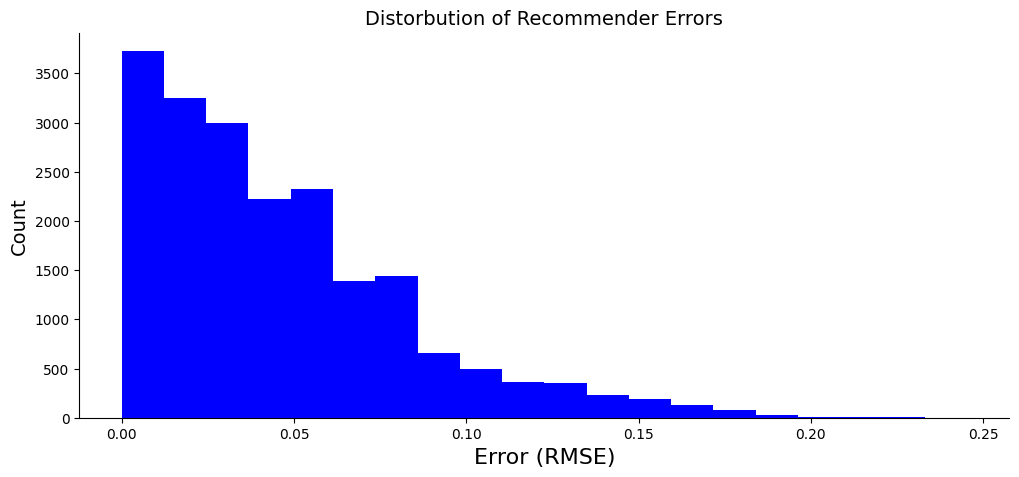

In [ ]:
# plot model error
plt.figure(figsize=(12,5))
plt.hist(recommendation_results.err, color='blue', bins=20)
plt.xlabel('Error (RMSE)', size=16)
plt.ylabel('Count', size=14)
plt.title('Distorbution of Recommender Errors', size=14)
sns.despine();

In [ ]:
def means_per_rating_group(dataset):
    real_over_three = dataset[dataset.rui > .10].err
    real_three_under = dataset[dataset.rui <= .10].err
    
    print("Overall recommendation system mean error:", dataset.err.mean())
    print("Mean error for products where user rates above 3:", real_over_three.mean())
    print("Mean error for products where user rates below 3:", real_three_under.mean())
    
    return real_over_three, real_three_under

real_over_three, real_three_under = means_per_rating_group(recommendation_results)

Overall recommendation system mean error: 0.04567807531885571
Mean error for products where user rates above 3: 0.03947187750295933
Mean error for products where user rates below 3: 0.13096042767640664


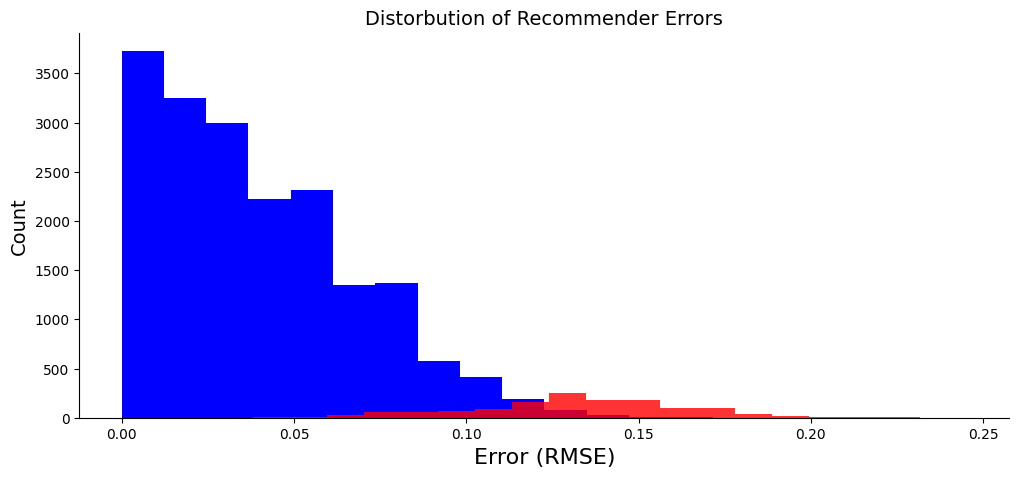

In [ ]:
# plot the recommendation system mean for users who rate products higher than 3 and lower than 3
plt.figure(figsize=(12,5))
plt.hist(real_over_three, bins=20, color='blue', label='Actual Rating >3')
plt.hist(real_three_under, bins=20, color='red', alpha=.8, label='Actual Rating <=3')
plt.xlabel('Error (RMSE)', size=16)
plt.ylabel('Count', size=14)
plt.title('Distorbution of Recommender Errors', size=14)
sns.despine();